In [1]:
import  torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
#loading the dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(len(train_dataset))
print(len(test_dataset))
print(len(train_loader))
print(len(test_loader))

Files already downloaded and verified
Files already downloaded and verified
50000
10000
782
157


In [8]:
print(test_dataset.data.shape) # 10000 images of 32x32 pixels with 3 channels
print(train_dataset.data.shape) # 50000 images
print(train_dataset)
train_dataset.__getitem__(0)[0].shape


(10000, 32, 32, 3)
(50000, 32, 32, 3)
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


torch.Size([3, 32, 32])

frog


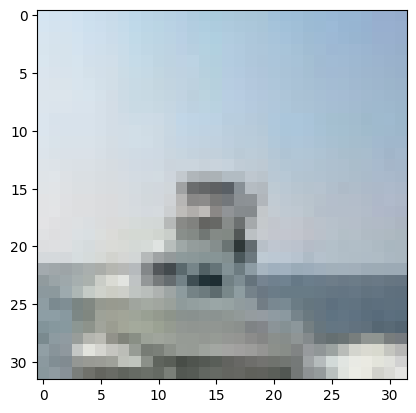

In [6]:
def showimg(img):
    img = plt.imshow(np.transpose(img, (1, 2, 0))) # convert from tensor to image,pytorch saves in channel first format, convert it to channel last format
    plt.show()
img, label = train_dataset[0]
print(classes[label]) 
showimg(train_dataset[100][0].numpy())

In [10]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 pool
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel
        self.pool =nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120) # 16 channels of 5x5 pixels, 120 output channels
        self.fc2 = nn.Linear(120, 84) # 120 input channels, 84 output channels
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
    

In [11]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [17]:
inputs, labels = next(iter(train_loader))
print(inputs.shape, labels.shape)


torch.Size([64, 3, 32, 32]) torch.Size([64])


In [28]:
n_epochs = 30
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs,labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() #This clears the gradients from the previous iteration.
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
print(' Training is complete')

[1,   100] loss: 1.056
[1,   200] loss: 1.107
[1,   300] loss: 1.089
[1,   400] loss: 1.092
[1,   500] loss: 1.137
[1,   600] loss: 1.084
[1,   700] loss: 1.098
[2,   100] loss: 1.093
[2,   200] loss: 1.070
[2,   300] loss: 1.089
[2,   400] loss: 1.083
[2,   500] loss: 1.087
[2,   600] loss: 1.104
[2,   700] loss: 1.072
[3,   100] loss: 1.052
[3,   200] loss: 1.080
[3,   300] loss: 1.049
[3,   400] loss: 1.044
[3,   500] loss: 1.055
[3,   600] loss: 1.082
[3,   700] loss: 1.080
[4,   100] loss: 1.031
[4,   200] loss: 1.035
[4,   300] loss: 1.054
[4,   400] loss: 1.040
[4,   500] loss: 1.080
[4,   600] loss: 1.037
[4,   700] loss: 1.058
[5,   100] loss: 1.020
[5,   200] loss: 1.014
[5,   300] loss: 1.062
[5,   400] loss: 1.034
[5,   500] loss: 1.052
[5,   600] loss: 1.050
[5,   700] loss: 1.025
[6,   100] loss: 1.000
[6,   200] loss: 1.020
[6,   300] loss: 1.032
[6,   400] loss: 1.032
[6,   500] loss: 1.007
[6,   600] loss: 1.033
[6,   700] loss: 1.041
[7,   100] loss: 1.015
[7,   200] 

In [29]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        for i in range(labels.size(0)):  # Use actual batch size instead of hardcoded 64
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network: {acc} %')
for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 62.77 %
Accuracy of plane: 68.6 %
Accuracy of car: 71.9 %
Accuracy of bird: 44.6 %
Accuracy of cat: 37.7 %
Accuracy of deer: 59.1 %
Accuracy of dog: 46.1 %
Accuracy of frog: 73.5 %
Accuracy of horse: 75.8 %
Accuracy of ship: 72.2 %
Accuracy of truck: 78.2 %


For 30 epochs the overall acuuuracy was **62.77%**

# Lets Try to improve the accuracy of this model :


In [ ]:
n_epochs = 30
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs,labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() #This clears the gradients from the previous iteration.
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
print(' Training is complete')